In [ ]:
!pip install yellowbrick

In [1]:
import pandas as pd
import numpy as np
import xlwings as xw
import glob
import os
import tsfel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from yellowbrick.model_selection import validation_curve



### Data with signal

In [50]:
xl = r'C:\Users\emilh\Desktop\Data_split\Full data\AEPrec_sABRe_data_TPsABR21_BILATERAL_2021-Aug-18_13.09.55.xlsx'

try:
    excel_app=xw.App(visible=False)
    wb=excel_app.books.open(xl)
    for sheet in wb.sheets:
        sheet.api.Copy()
        wb_new=xw.books.active
        wb_new.save(f'{xl+sheet.name}.xlsx')
        wb_new.close()
finally:
    excel_app.quit()

In [24]:
cwd=os.chdir(r'C:\Users\emhm\Desktop\Data\Simp_Data')
files=os.listdir(cwd)

wsig=pd.DataFrame()
for file in files:
    if file.endswith('.xlsx'):
        wsig=wsig.append(pd.read_excel(file), ignore_index=True)

wsig.head()
wsig.insert(961, 'Label', '1')
wsig.to_excel('data.xlsx')

C:\Users\emhm\AppData\Local\Temp\ipykernel_22996\4193199951.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wsig=wsig.append(pd.read_excel(file), ignore_index=True)
C:\Users\emhm\AppData\Local\Temp\ipykernel_22996\4193199951.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wsig=wsig.append(pd.read_excel(file), ignore_index=True)
C:\Users\emhm\AppData\Local\Temp\ipykernel_22996\4193199951.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wsig=wsig.append(pd.read_excel(file), ignore_index=True)
C:\Users\emhm\AppData\Local\Temp\ipykernel_22996\4193199951.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wsig=wsig.append(pd.read_

In [14]:
file = pd.read_excel(r'C:\Users\emhm\Desktop\Simp_Data\data.xlsx')
file.insert(960, 'Label', '1')

### Data without signal

In [9]:
no_sig=pd.read_excel(r'C:\Users\emhm\Desktop\Data\No_sig_data\ABR_Noise.xlsx')
no_sig.insert(960, 'Label', '0')
no_sig.to_excel('ABR_Noise_Edit.xlsx')

### Final data

In [26]:
cwd=os.chdir(r'C:\Users\emhm\Desktop\Final_Data')
files=os.listdir(cwd)

df_final=pd.concat([no_sig, wsig], axis=0)
df_final.to_excel('final_data.xlsx')

## Feature extraction

In [7]:
data=pd.read_excel(r'C:\Users\emhm\Desktop\Final_Data\final_data.xlsx')
X=data.drop('Label', axis=1)
y=data.loc[:, 'Label']

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)


(281, 960) (281,)


In [20]:
cfg = tsfel.get_features_by_domain()

feature_train = tsfel.time_series_features_extractor(cfg, X_train.values, fs=20)
feature_test = tsfel.time_series_features_extractor(cfg, X_test.values, fs=20)

*** Feature extraction started ***


C:\Users\emhm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tsfel\feature_extraction\calc_features.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_final = features_final.append(feat)
C:\Users\emhm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tsfel\feature_extraction\calc_features.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_final = features_final.append(feat)
C:\Users\emhm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tsfel\feature_extraction\calc_features.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f


*** Feature extraction finished ***
*** Feature extraction started ***


C:\Users\emhm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tsfel\feature_extraction\calc_features.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_final = features_final.append(feat)
C:\Users\emhm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tsfel\feature_extraction\calc_features.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_final = features_final.append(feat)
C:\Users\emhm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tsfel\feature_extraction\calc_features.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f


*** Feature extraction finished ***


In [21]:
feature_train

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,...,0_Wavelet variance_0,0_Wavelet variance_1,0_Wavelet variance_2,0_Wavelet variance_3,0_Wavelet variance_4,0_Wavelet variance_5,0_Wavelet variance_6,0_Wavelet variance_7,0_Wavelet variance_8,0_Zero crossing rate
0,4.137314e+06,2287.188362,4.137314e+06,22.771537,192.0,768.0,-56.929500,55.827600,0.001042,0.002083,...,2983.336962,11684.406592,19887.015588,16631.461999,8591.614031,3169.131768,930.297839,274.962869,125.727450,258.0
1,3.462244e+06,2335.102965,3.462244e+06,28.034650,192.0,768.0,-47.755405,56.353710,0.001042,0.002083,...,0.722784,9.603008,43.219149,112.498754,217.911198,356.324568,528.892978,745.503086,1025.001330,12.0
2,5.479786e+06,2926.350395,5.479786e+06,19.436613,192.0,768.0,-58.989315,55.306030,0.001042,0.002083,...,1.192604,15.265183,66.778342,172.719041,337.620789,564.683449,863.015679,1246.645188,1730.780917,6.0
3,3.735901e+06,2087.720132,3.735901e+06,18.114240,192.0,768.0,-14.474008,47.024197,0.001042,0.002083,...,1.314086,17.317608,75.487801,194.568590,385.713049,665.652169,1060.195108,1603.258911,2333.879298,13.0
4,6.121665e+06,3249.145610,6.121665e+06,26.900683,192.0,768.0,-64.676964,70.006126,0.001042,0.002083,...,0.808856,9.278420,39.608545,105.869123,221.309055,396.465020,639.918773,961.564316,1374.213240,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,1.137070e+07,4079.668672,1.137070e+07,22.529568,192.0,768.0,-65.741882,81.579918,0.001042,0.002083,...,1.037235,17.121316,87.011910,263.886225,619.406023,1252.578080,2281.794655,3829.035272,6006.707134,7.0
277,3.796571e+06,2115.817460,3.796571e+06,24.220901,192.0,768.0,-51.298800,53.335800,0.001042,0.002083,...,3165.521097,11069.517659,15574.774166,12426.385155,6382.280861,2282.467455,611.984927,136.322987,34.775905,304.0
278,8.646397e+06,3581.099495,8.646397e+06,21.633885,192.0,768.0,1.659651,83.335205,0.001042,0.002083,...,0.935155,17.348196,93.781890,302.946312,739.906204,1515.029476,2748.194807,4557.931381,7044.496410,6.0
279,4.109582e+06,2185.434460,4.109582e+06,23.673139,192.0,768.0,-55.219300,51.237300,0.001042,0.002083,...,3444.064060,11797.023522,16774.337502,14174.317742,7431.250158,2581.315957,649.295649,143.004658,45.706961,303.0


## Accuracy functions

In [5]:
def get_confusion_matrix(y, y_pred, model):
    
    conf_matrix = confusion_matrix(y, y_pred)
    df_cm = pd.DataFrame(conf_matrix,index = ['Signal','No Signal'], columns = ['Signal','No Signal'])
    sns.set(font_scale = 1.4)
    sns.heatmap(df_cm, annot = True, cmap = 'OrRd', fmt = 'g', annot_kws={"size": 16}) # font size
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.title('%s - Confusion Matrix' %model)
    #plt.savefig('confusion_matrix.png', dpi = 100, bbox_inches='tight' )
    plt.show()
    plt.close()

    return conf_matrix


def get_normalized_confusion_matrix(y, y_pred, model):
    
    conf_matrix = confusion_matrix(y, y_pred)
    conf_matrix = conf_matrix.astype(float)/conf_matrix.sum(axis = 1)[:,np.newaxis]
    df_cm = pd.DataFrame(conf_matrix,index = ['Signal','No Signal'], columns = ['Signal','No Signal'])
    sns.set(font_scale = 1.4)
    sns.heatmap(df_cm, annot = True, cmap = 'OrRd', fmt = '.2f',annot_kws={"size": 16}) # font size
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.title('%s - Normalized Confusion Matrix' %model)
    #plt.savefig('confusion_matrix.png', dpi = 100, bbox_inches='tight' )
    plt.show()
    plt.close()
    
    return conf_matrix


# Based on Sensitivity and Recall 
# https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7
def get_matthews_corrcoef(y_pred, y_true):
    cov = np.cov(y_true, y_pred)
    if cov[0,0]==0. or cov[1,1]==0.:
        return 0.
    else:
        return cov[0,1]/np.sqrt(cov[0,0]*cov[1,1]) 
    
    
# Precision-Recall curve to evaluate a model
# PR curves are specifically tailored for the detection of rare events
def get_precision_recall_curve(y_true, y_pred):
    #precision, recall, thresholds = precision_recall_curve(y_test, probs)
    return plot_precision_recall_curve(classifier, X_test, y_test)
  
    
    
# ROC curves can sometimes be misleading in some very imbalanced applications
def get_roc_curve(y_true, y_pred_proba, model):
    
    #keep probabilities for the positive outcome only
    y_pred_proba = y_pred_proba[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    auc = roc_auc_score(y_true, y_pred_proba)
    print('ROC AUC=%.3f' % (auc))
    
    plt.plot([0,1],[0,1],linestyle = '--',lw = 0.8,color = 'black', label='Luck')
    plt.plot(fpr, tpr, marker='.', lw=2, color='red', label=r'ROC (AUC = %0.3f )' % (auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(r'%s - ROC curve' % (model))
    plt.legend(loc = 'lower right')
    plt.show()
    
    return auc
    

## Random forrest

In [15]:
rf = RandomForestClassifier(random_state=42,  warm_start=True)

#### Find optimal number of estimators

KeyboardInterrupt: 

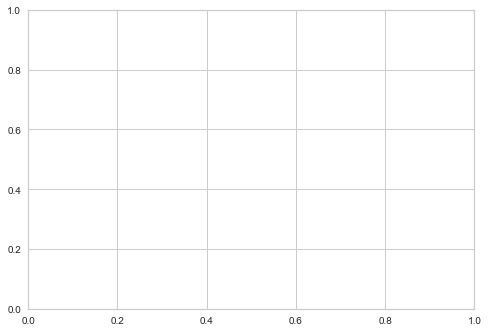

In [16]:
rfc = RandomForestClassifier(random_state=42,  warm_start=True)

viz = validation_curve(
    rfc, X, y, param_name="n_estimators",
    param_range=np.arange(10,350,20), cv=10, scoring="roc_auc",
)

#### Find optimal depth 

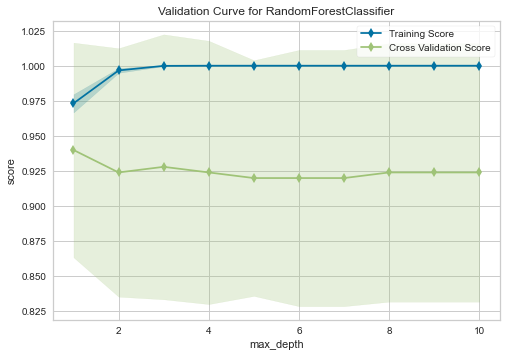

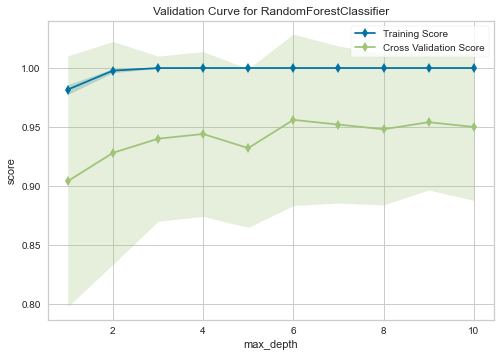

In [34]:
rfc = RandomForestClassifier(random_state=42,  warm_start=True,  n_estimators=110)

viz = validation_curve(
    rfc, X, y, param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="roc_auc",
)

viz = validation_curve(
    rf, X, y, param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="roc_auc",
)

#### Find best min_sample_leaf

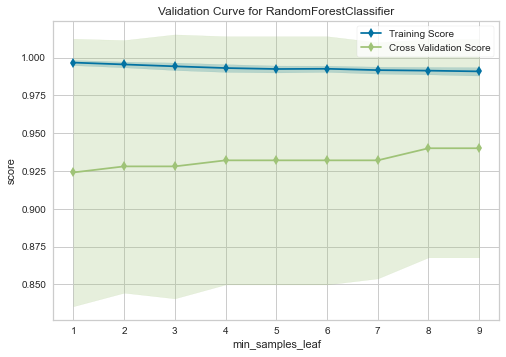

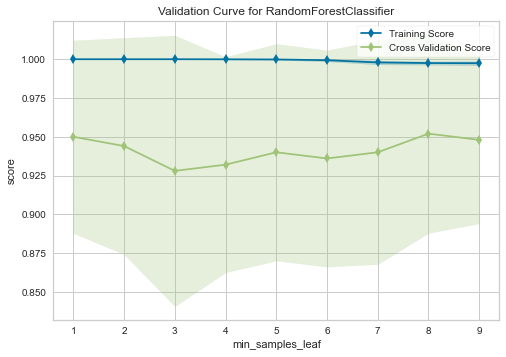

In [38]:
rfc = RandomForestClassifier(random_state=42,  warm_start=True, n_estimators=110, max_depth=2 )

viz = validation_curve(
    rfc, X, y, param_name="min_samples_leaf",
    param_range=np.arange(1, 10), cv=10, scoring="roc_auc",
)

viz = validation_curve(
    rf, X, y, param_name="min_samples_leaf",
    param_range=np.arange(1, 10), cv=10, scoring="roc_auc",
)

#### Find best max_features

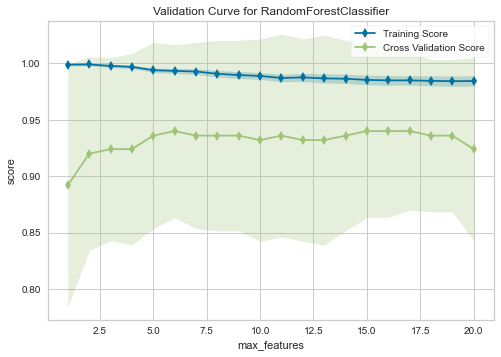

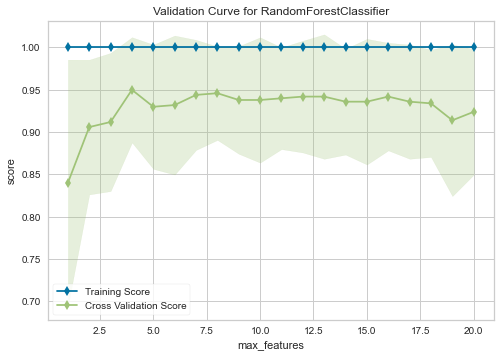

In [42]:
rfc = RandomForestClassifier(random_state=42,  warm_start=True,  n_estimators=400, max_depth=2 )

viz = validation_curve(
    rfc, X, y, param_name="max_features",
    param_range=np.arange(1, 400), cv=10, scoring="roc_auc",
)

viz = validation_curve(
    rf, X, y, param_name="max_features",
    param_range=np.arange(1, 400), cv=10, scoring="roc_auc",
)

#### Find best parametres with GridSearchCV

In [41]:
rf_clf = RandomForestClassifier(random_state=42,  warm_start=True)
param_grid = {
    'n_estimators': [150, 200, 250, 300, 350, 400],
    'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_leaf' : [1, 2, 3, 4],
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#    'criterion' :['gini', 'entropy']
             }
CV_rfc = GridSearchCV(estimator=rf,param_grid=param_grid,n_jobs = -1, scoring='roc_auc', cv= 10)
CV_rfc.fit(X_rfc, y_rfc)
print('BEST PARAMETERS:\n',CV_rfc.best_params_)
print('BEST SCORE:\n',CV_rfc.best_score_)

NameError: name 'rs' is not defined

In [24]:
rf_clf=RandomForestClassifier(max_depth=16, random_state=2)
rf_clf.fit(feature_train, y_train)

y_pred=rf_clf.predict(feature_test)
accuracy_score(y_test, y_pred)

1.0

### Adaboost

In [17]:
ada_clf=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                            n_estimators=100,
                            algorithm='SAMME',
                            random_state=0,
                            learning_rate=1.0)

ada_clf.fit(X_train, y_train)

ada_clf.estimator_weights_

array([2.05171699, 1.77574515, 1.53086092, 1.54621269, 1.71179636,
       1.45704823, 1.55233133, 1.34120173, 1.59909263, 1.65567957,
       1.20715321, 1.48863066, 1.56383125, 1.5617009 , 1.4220972 ,
       1.36598444, 1.9774737 , 1.61193594, 1.4419597 , 1.60701739,
       1.41959232, 1.69241193, 1.42487516, 1.68953299, 1.58179836,
       1.57914852, 1.35694033, 1.49026352, 1.61195121, 1.91050469,
       1.55347753, 1.77042778, 1.65516468, 1.39814201, 1.33796908,
       1.68899138, 1.51632837, 1.16319577, 1.84012742, 1.53584425,
       1.7673282 , 1.35642613, 1.58352743, 1.33260441, 1.31503464,
       1.9150287 , 1.13261809, 1.53075845, 1.66721954, 1.68921096,
       1.24633138, 1.67257522, 1.45826085, 1.89767174, 1.55067109,
       1.47831446, 1.26373782, 1.75796456, 1.43815136, 1.77861776,
       1.5677971 , 1.572437  , 1.64655234, 1.3939341 , 1.56056292,
       1.32372802, 1.70165874, 1.67438545, 1.78111739, 1.53407827,
       1.3794701 , 1.58584679, 1.70440186, 1.46676755, 1.63322

In [18]:
y_pred=ada_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.971830985915493

Adaboost 2# attempt